In [1]:
# Import Libraries
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import math
import scipy

# Data loading

In [31]:
# Load data
patients_dataset_df = pd.read_excel('Databases/svedem_dataset_processed.xlsx')
patients_dataset_df.drop("Unnamed: 0", axis=1, inplace=True)

# Variables definition

In [3]:
continuous_feat = ['AGE', 'DAYS_DIFF_FU', 'DAYS_DIFF_FU_WRT_FU', 'AGE_BR'] # DAYS_DIFF_FU, DAYS_DIFF_FU_WRT_FU, DAYS_ALIVE_DIAGNOS
cat_static_feat = [ 'GENDER', 'SC_FLAG']
cat_dynamic_feat = ['DIAGNOSIS', 'CENTRE_TYPE_ID', 'GLOBAL_ESTIMATE_COGNITION_FU', 'RESIDENCY']

drugs_df = pd.read_excel('Databases/Drugs_codes.xlsx', sheet_name= 4, skiprows = 1)
drug_vars = drugs_df.loc[drugs_df['Percentage wrt database observations'] >= 5, 'Drug name']
drug_vars_aux = drug_vars.tolist()
drug_vars_aux.sort()
drug_vars = pd.Series(drug_vars_aux)
drug_vars[drug_vars[drug_vars == "Calcium, combinations with vitamin D and/or other drugs"].index] = "Calcium, VitD and others"

# Clustering and Identification Simulations

In [30]:
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency, ttest_ind, gaussian_kde, kruskal
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy import interpolate
from scipy.spatial import ConvexHull
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep
from scipy.stats.mstats import gmean
import scipy.stats as st

%matplotlib qt

# Choose clustering parameters
clust_analysis_flag = False # If true Elbow, silhouette and gap methods are carried for different clusters to decide the optimal number of clusters
plt_surface_flag = True
tridim_flag = False
KLdiv_Flag = False
save_Flag = True
n_clust = 4
N_FU_max = 4
MC_flag = True # To indicate the number of times we are do the clustering
if MC_flag == True:
    n_MC = 100
else:
    n_MC = 1
    
patients_dataset_clst_df = patients_dataset_df.copy()
vars_count = pd.DataFrame(data = np.zeros((1,len(drug_vars)), dtype=int), columns=(drug_vars), index = ['Count'])
for n_FU in range(1, N_FU_max):
    if n_FU == 1:
        title_name = "1st Follow-up"
    elif n_FU == 2:
        title_name = "2nd Follow-up"
    else:
        title_name = "{}th Follow-up".format(n_FU)
    print("Clustering for the {}".format(title_name))

# Data preparation
    X_fu = patients_dataset_df[patients_dataset_df['NUMBER_FOLLOWUP'] == n_FU].copy()
    X_aux1 = X_fu[['MMSE_SCORE', 'MMSE_DECL', 'DAYS_DIFF_FU']]
    if n_FU == 1:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(X_fu['MMSE_SCORE'], X_fu['MMSE_DECL'], X_fu['DAYS_DIFF_FU'], alpha=0.4, s=10)
        ax.set_xlabel('MMSE Score', fontsize =25)
        ax.set_ylabel('MMSE Decline', fontsize =25)
        ax.set_zlabel('Days from BR', fontsize =25)
        ax.set_title('FU1 patients plot', fontsize =35)
        ax.tick_params(axis='both', which='major', labelsize=25)
        plt.savefig('Analysis Figures/FU_patients_3d.jpg', dpi=300)
        plt.show()

    # The main differences between minmax scaler and standard scaler are:       
        #   - MinMax: feature range (0,1) transforms each value proportionally to this range. It preserves the shape of the dataset without distortion. 
        #   - Standard: feature range around the mean 0 and std of 1. Each value is normalized substracting teh mean and dividing by the standard deviation. Used if the data distribution is normal. If outliers are present it influences the empirical mean and std shrinking the range of the feature values. Use if the data is not gaussian distributed.
    sc_minmax = MinMaxScaler()
    sc_stand = StandardScaler()
    X_trans = X_fu[['MMSE_SCORE', 'MMSE_DECL', 'DAYS_DIFF_FU']].copy() # "DAYS_DIFF_FU" is not really used to cluster, thats why we are not scaling it properly, but we include it for visualization
    X_trans = pd.DataFrame(np.hstack((sc_stand.fit_transform(X_fu[['MMSE_SCORE', 'MMSE_DECL']]), sc_minmax.fit_transform(X_trans[['DAYS_DIFF_FU']]))), index=X_trans.index, columns=X_trans.columns)

# Explore optimal number of cluster
    if clust_analysis_flag == True:
        elbow_distortions = []
        silhouette_s = []
        n_gap_refs = 10 # For gap statistic method: Number of sample reference datasets to create
        gap_scores = []
        K = range(1,10)
        for k in K:
            model = KMeans(n_clusters = k)
            model.fit(X_trans)
                # 1) Elbow method
            model_inertia = model.inertia_
            elbow_distortions.append(model_inertia)
                # 2) Silhouette method
            if k != 1:
                silhouette_s.append(silhouette_score(X_trans, model.labels_, metric='euclidean'))
            else: 
                silhouette_s.append(0)
                # 3) Gap statistics method
            ref_gap_disps = []
            for i in range(n_gap_refs):
                random_Ref = np.random.random_sample(size = X_trans.shape)
                ref_gap_disps.append(KMeans(n_clusters = k).fit(random_Ref).inertia_)
            gap_scores.append(np.log(np.mean(ref_gap_disps)) - np.log(model_inertia))
        fig, axs = plt.subplots(1, 3, figsize=(25,8))
        plt.subplots_adjust(hspace=0.5, wspace=0.5)
        #fig.suptitle("Methods to determine the optimal number of clusters for the {}".format(title_name), fontsize=18, y=0.95)
        axs = axs.flatten()
        for i in range(0,3):
            if i == 0:
                axs[i].plot(K, elbow_distortions, 'bx-')
                axs[i].set_xlabel('k', fontsize = 25)
                axs[i].set_ylabel('Distortion', fontsize =25)
                axs[i].set_title('Elbow Method', fontsize = 30)   
            if i == 1:
                axs[i].plot(K, silhouette_s, 'bx-')
                axs[i].set_xlabel('k', fontsize = 25, labelpad=20)
                axs[i].set_ylabel('Average silhouette width', fontsize =  25, labelpad=20)
                axs[i].set_title('Silhouette Method', fontsize = 20)  
            if i == 2:
                axs[i].plot(K, gap_scores, 'bx-')
                axs[i].set_xlabel('k', fontsize = 25)
                axs[i].set_ylabel('Gap statistic (k)', fontsize = 25, labelpad=20)
                axs[i].set_title('Gap Statistic', fontsize = 30)  
                axs[i].tick_params(axis='both', which='major', labelsize=25)
        plt.show()
    
# Plot follow-up density plot
    x = X_fu['MMSE_SCORE']
    y = X_fu['MMSE_DECL']
     # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
     # Sort to have the dense points on top
    idx = z.argsort()
    x, y, z = x.iloc[idx], y.iloc[idx], z[idx]
     # Plot
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, cmap=plt.cm.jet, s=100)
    ax.set_xlabel('MMSE Score', fontsize =25, labelpad=20)
    ax.set_ylabel('MMSE Decline', fontsize =25, labelpad=20)
    ax.set_title("{} patients density distribution".format(title_name), fontsize =35)
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.set_xlim([-1,31])
    ax.set_ylim([-31,31])
    plt.show()

# K-Means clustering
    vars_count_MC = pd.DataFrame(data = np.zeros((1,len(drug_vars)), dtype=int), columns=(drug_vars), index = ['Count'])   
    vars_pvals_MC = pd.DataFrame(np.nan, index=range(0, n_MC), columns=(drug_vars))
    vars_pvals_corr_MC = pd.DataFrame(np.nan, index=range(0, n_MC), columns=(drug_vars)) 
    for clst in range(n_clust):
        for clst_compare in range(clst+1, n_clust):
            exec(f'vars_count_MC_clst{clst}_{clst_compare} = pd.DataFrame(data = np.zeros((1,len(drug_vars)), dtype=int), columns=(drug_vars), index = ["Count"])')   
            exec(f'vars_pvals_MC_clst{clst}_{clst_compare} = pd.DataFrame(np.nan, index=range(0, n_MC), columns=(drug_vars))')
            exec(f'vars_confint_MC_clst{clst}_{clst_compare} = pd.DataFrame(np.nan, index=range(0, n_MC), columns=(drug_vars))')
            exec(f'vars_score_MC_clst{clst}_{clst_compare} = pd.DataFrame(np.nan, index=range(0, n_MC), columns=(drug_vars))')
            exec(f'vars_score_MC_clst{clst}_{clst_compare}_corr = pd.DataFrame(np.nan, index=range(0, n_MC), columns=(drug_vars))')
            exec(f'vars_pvals_corr_MC_clst{clst}_{clst_compare} = pd.DataFrame(np.nan, index=range(0, n_MC), columns=(drug_vars))')
    for mc in range(0, n_MC):
        X_clst = X_fu.copy()
        kmeans = KMeans(n_clusters = n_clust, n_init = 25, max_iter = 600)
        clustered = kmeans.fit_predict(X_trans)

        X_clst['Cluster_prov'] = clustered 
        centroids = kmeans.cluster_centers_
        cen_x_prov = [i[0] for i in centroids] 
        cen_y_prov = [i[1] for i in centroids]
        cen_z_prov = [i[2] for i in centroids]

        # Order the clusters to always be descending in mean MMSE_SCORE. From best to worst 
        clst_score = []
        clsts = np.unique(clustered)
        for clst in clsts:
            clst_score.append(X_clst[X_clst['Cluster_prov']==clst]['MMSE_SCORE'].mean())
        order = np.argsort(clst_score)[::-1]
        X_clst['Cluster'] = -1
        for clst, i in enumerate(order): 
            X_clst.loc[(X_clst['Cluster_prov'] == i), 'Cluster'] = clst
        X_clst.drop('Cluster_prov', inplace=True, axis=1)
        cen_x = [cen_x_prov[i] for i in order]
        cen_y = [cen_y_prov[i] for i in order]
        cen_z = [cen_z_prov[i] for i in order]
        
        X_clst['Cen_x'] = X_clst.Cluster.map({clst:cen_x[clst] for clst in range(n_clust)})
        X_clst['Cen_y'] = X_clst.Cluster.map({clst:cen_y[clst] for clst in range(n_clust)})
        X_clst['Cen_z'] = X_clst.Cluster.map({clst:cen_z[clst] for clst in range(n_clust)})

        if mc == n_MC-1:
            palette = plt.cm.hsv(np.linspace(0, 1, n_clust+1))
            reord = np.array([1, 3, 2, 0])
            new_pal = palette[reord,]
            cen_xy = sc_stand.inverse_transform(np.transpose([cen_x, cen_y]))
            cen_x = cen_xy[:,0]
            cen_y = cen_xy[:,1]
            if tridim_flag == True:
                fig = plt.figure()
                ax = fig.add_subplot(projection='3d')
                cen_z = sc_minmax.inverse_transform([cen_z])[0]
                for clst, c in zip(range(n_clust), new_pal):
                    points = X_clst[X_clst['Cluster']==clst].copy()
                        # Plot points
                    ax.scatter(points['MMSE_SCORE'], points['MMSE_DECL'], points['DAYS_DIFF_FU'], c = np.array([c]), label='Cluster {}'.format(clst+1), alpha=0.1, s=10)
                        # Plot centroids
                    ax.scatter(cen_x[clst], cen_y[clst], cen_z[clst], marker='^', c = np.array([c]), s=70)
                        # Get the convex hull for cluster area
                    if plt_surface_flag == True:
                        vals = points[['MMSE_SCORE', 'MMSE_DECL', 'DAYS_DIFF_FU']].values
                        hull = ConvexHull(vals)
                            # Plot shape
                        x_hull = []
                        y_hull = []
                        z_hull = []
                        vertices = hull.vertices
                        simplices = hull.simplices
                        for i in range(len(simplices)):
                            s = simplices[i,:]
                            x_hull.append(vals[s, 0])
                            y_hull.append(vals[s, 1])
                            z_hull.append(vals[s, 2])
                        ax.plot_surface(np.array(x_hull), np.array(y_hull), np.array(z_hull), color = np.array([c]), alpha=0.1)
                ax.set_xlabel('MMSE Score', fontsize =25, labelpad=20)
                ax.set_ylabel('MMSE Decline', fontsize =25, labelpad=20)
                ax.set_zlabel('Days from BR', fontsize =25, labelpad=20)
                ax.set_title("{} Patients clustering".format(title_name), fontsize =35)
                ax.tick_params(axis='both', which='major', labelsize=25)
                leg = plt.legend(fontsize =25, markerscale=2)
                for lh in leg.legendHandles:
                    lh.set_alpha(1)
                exec(f'plt.savefig("Analysis Figures/3d_patients_clst_FU{n_FU}.jpg", dpi=300)')
                plt.show()

                # Convert the MMSE Score(t)/Decline plot to MMSE Score(t)/Score(t-1) plot
                fig = plt.figure()
                ax = fig.add_subplot(projection='3d')
                palette = plt.cm.hsv(np.linspace(0, 1, n_clust+1))
                reord = np.array([1, 3, 2, 0])
                new_pal = palette[reord,]
                for clst, c in zip(range(n_clust), new_pal):
                    points = X_clst[X_clst['Cluster']==clst].copy()
                        # Plot points
                    ax.scatter(points['MMSE_SCORE'], points['MMSE_SCORE']-points['MMSE_DECL'], points['DAYS_DIFF_FU'], c = np.array([c]), label='Cluster {}'.format(clst+1), alpha=0.1, s=10)
                        # Plot centroids
                    ax.scatter(cen_x[clst], cen_x[clst]-cen_y[clst], cen_z[clst], marker='^', c = np.array([c]), s=70)
                ax.set_xlabel('MMSE Score (t)', fontsize =25, labelpad=20)
                ax.set_ylabel('MMSE Score (t-1)', fontsize =25, labelpad=20)
                ax.set_zlabel('Days from BR', fontsize =25, labelpad=20)
                ax.set_title("{} Patients clustering".format(title_name), fontsize =35)
                ax.tick_params(axis='both', which='major', labelsize=25)
                leg = plt.legend(fontsize =25, markerscale=2)
                for lh in leg.legendHandles:
                    lh.set_alpha(1)
                exec(f'plt.savefig("Analysis Figures/3d_patients_transformed_clst_FU{n_FU}.jpg", dpi=300)')
                plt.show()
            elif tridim_flag == False: #2D plot
                fig = plt.figure(figsize=(15,15))
                ax = fig.add_subplot()
                for clst, c in zip(range(n_clust), new_pal):
                    points = X_clst[X_clst['Cluster']==clst].copy()
                        # Plot points
                    plt.scatter(points['MMSE_SCORE'], points['MMSE_DECL'], c = np.array([c]), label='Cluster {}'.format(clst+1), alpha=0.1, s=20)
                        # Plot centroids
                    plt.scatter(cen_x[clst], cen_y[clst], marker='^', c = np.array([c]), s=70)
                        # Get the convex hull for cluster area
                    if plt_surface_flag == True:
                        vals = points[['MMSE_SCORE', 'MMSE_DECL']].values
                        hull = ConvexHull(vals)
                            # Plot shape
                        x_hull = np.append(vals[hull.vertices,0], vals[hull.vertices,0][0])
                        y_hull = np.append(vals[hull.vertices,1], vals[hull.vertices,1][0])
                        plt.fill(np.array(x_hull), np.array(y_hull), color = np.array([c]), alpha=0.2)
                plt.xlabel('MMSE Score', fontsize =30, labelpad=20)
                plt.ylabel('MMSE Decline', fontsize =30, labelpad=20)
                plt.title("{} Patients clustering".format(title_name), fontsize =35)
                plt.tick_params(axis='both', which='major', labelsize=25)
                plt.xlim(-3,33)
                plt.ylim(-33,33)
                plt.grid()
                leg = plt.legend(fontsize =25, markerscale=3)
                for lh in leg.legendHandles:
                    lh.set_alpha(1)
                ax.set_aspect('equal', adjustable='box')
                exec(f'plt.savefig("Analysis Figures/2d_patients_clst_FU{n_FU}.jpg", dpi=300)')
                plt.show()

                fig = plt.figure(figsize=(15,15))
                ax = fig.add_subplot()
                for clst, c in zip(range(n_clust), new_pal):
                    points = X_clst[X_clst['Cluster']==clst].copy()
                        # Plot points
                    ax.scatter(points['MMSE_SCORE'], points['MMSE_SCORE']-points['MMSE_DECL'], c = np.array([c]), label='Cluster {}'.format(clst+1), alpha=0.1, s=20)
                        # Plot centroids
                    ax.scatter(cen_x[clst], cen_x[clst]-cen_y[clst], marker='^', c = np.array([c]), s=70)
                        # Get the convex hull for cluster area
                    if plt_surface_flag == True:
                        vals = points[['MMSE_SCORE', 'MMSE_DECL']].values
                        vals[:,1] = vals[:,0] - vals[:,1]
                        hull = ConvexHull(vals)
                            # Plot shape
                        x_hull = np.append(vals[hull.vertices,0], vals[hull.vertices,0][0])
                        y_hull = np.append(vals[hull.vertices,1], vals[hull.vertices,1][0])
                        plt.fill(np.array(x_hull), np.array(y_hull), color = np.array([c]), alpha=0.2)
                ax.set_xlabel('MMSE Score (t)', fontsize =30, labelpad=20)
                ax.set_ylabel('MMSE Score (t-1)', fontsize =30, labelpad=20)
                ax.set_title("{} Patients clustering".format(title_name), fontsize =35)
                ax.tick_params(axis='both', which='major', labelsize=25)
                plt.xlim(-3,33)
                plt.ylim(-3,33)
                plt.grid()
                leg = plt.legend(fontsize = 25, markerscale=3)
                for lh in leg.legendHandles:
                    lh.set_alpha(1)
                ax.set_aspect('equal', adjustable='box')
                exec(f'plt.savefig("Analysis Figures/2d_patients_transformed_clst_FU{n_FU}.jpg", dpi=300)')
                plt.show()

    # Compute cluster variables' statistics and relevance
        if mc == n_MC-1:
            clst_score_mean = []
            clst_score_std = []
            clst_decl_mean = []
            clst_decl_std = []
            clst_days_mean = []
            clst_days_std = []
            for clst in np.unique(clustered):
                clst_score_mean.append(X_clst[X_clst['Cluster']==clst]['MMSE_SCORE'].mean())
                clst_score_std.append(X_clst[X_clst['Cluster']==clst]['MMSE_SCORE'].std())
                clst_decl_mean.append(X_clst[X_clst['Cluster']==clst]['MMSE_DECL'].mean())
                clst_decl_std.append(X_clst[X_clst['Cluster']==clst]['MMSE_DECL'].std())
                clst_days_mean.append(X_clst[X_clst['Cluster']==clst]['DAYS_DIFF_FU'].mean())
                clst_days_std.append(X_clst[X_clst['Cluster']==clst]['DAYS_DIFF_FU'].std())
                print('Cluster {} has {} occurrences and:'.format(clst+1, X_clst['Cluster'].value_counts()[clst]))
                print('\tMMSE Score:{} \u00B1 {}'.format(clst_score_mean[-1], clst_score_std[-1]))
                print('\tMMSE Decline:{} \u00B1 {}'.format(clst_decl_mean[-1], clst_decl_std[-1]))
                print('\tDays diff BR-FU:{} \u00B1 {}'.format(clst_days_mean[-1], clst_days_std[-1]))
            exec(f'clst_score_mean_{n_FU}FU = clst_score_mean')
            exec(f'clst_score_std_{n_FU}FU = clst_score_std')
            exec(f'clst_decl_mean_{n_FU}FU = clst_decl_mean')
            exec(f'clst_decl_std_{n_FU}FU = clst_decl_std')
            exec(f'clst_days_mean_{n_FU}FU = clst_days_mean')
            exec(f'clst_days_std_{n_FU}FU = clst_days_std')

        # Create contingency table and compute p-value of each feature with Chi-2 method
        score_results = []
        p_vals = []
        for clst in range(n_clust):
            exec(f'var_clst_{clst} = []')
            exec(f'X_clst{clst} = X_clst[X_clst["Cluster"] == clst].copy()')
        for var in drug_vars: # Medications with not necessity of Yates correction
            cont_table = pd.crosstab(index = X_clst["Cluster"], columns = X_clst[var])
            chi2 = chi2_contingency(cont_table, correction = False)[:2]
            score_results.append(chi2)
            p_vals.append(chi2[1])
        # Apply Benjamini Hochberg correction to p-values to decrease the false discovery rate
        rejected, p_vals_corrected = fdrcorrection(pvals = p_vals, alpha = 0.05)
        vars_pvals_MC.iloc[mc, :] = p_vals
        vars_pvals_corr_MC.iloc[mc, :] = p_vals_corrected
        p_vals_corrected = p_vals_corrected[np.array(rejected)]
        score_results_corrected = list(np.concatenate((np.array(score_results, dtype=object)[np.array(rejected)], p_vals_corrected.reshape((-1,1))), axis=1))
        rel_vars = list(np.array(drug_vars, dtype=object)[np.array(rejected)])
        if (np.array(score_results_corrected, dtype=object).size != 0):
            vars_df = pd.DataFrame(np.array(score_results_corrected, dtype=object), index=rel_vars, columns=['Score', 'P-val', 'P-val corrected'])
            for var in rel_vars:
                for clst in range(n_clust):
                    if (X_clst.loc[(X_clst["Cluster"] == clst), var].value_counts().index == 1).any():
                        exec(f'var_clst_{clst}.append(X_clst.loc[(X_clst["Cluster"] == clst), var].value_counts()[1])')
                    else:
                        exec(f'var_clst_{clst}.append(0)')
            for clst in range(n_clust):
                exec(f'vars_df["Cluster_{clst}"] = var_clst_{clst}')
            if mc == n_MC-1:
                print("\n{}\n".format(vars_df.to_string()))

            if mc == n_MC-1:
                # Plot Relevant variables
                fig, axs = plt.subplots(math.ceil(len(rel_vars)/4), 4, figsize=(25, math.ceil(len(rel_vars)/4)*4))
                plt.subplots_adjust(hspace=0.5, wspace=0.5)
                fig.suptitle("Important variables in {} K-Mean clusters for the {}".format(n_clust+1, title_name), fontsize=18, y=0.95)
                axs = axs.flatten()
                for j in range(len(rel_vars)):
                    var = rel_vars[j]
                    X_var = X_clst[X_clst[var] == 1]
                    axs[j].bar(np.unique(clustered), X_var.groupby('Cluster')[var].value_counts().reindex([np.unique(clustered), np.ones((n_clust))], fill_value=0) / np.array(X_clst['Cluster'].value_counts().sort_index()))
                    axs[j].set_xlabel('Cluster', fontsize =30, labelpad=20)
                    axs[j].set_ylabel('Cluster Percentage', fontsize =30, labelpad=20)
                    axs[j].set_xticks([i for i in range(0,n_clust)])
                    axs[j].tick_params(axis='both', which='major', labelsize=25)
                    axs[j].set_title(var, fontsize = 35)
                plt.show()
            vars_count_MC[rel_vars] = vars_count_MC[rel_vars] + 1
            vars_count[rel_vars] = vars_count[rel_vars] + 1


         # Create contingency table and compute p-value of each feature with Chi-2 method for each cluster independently wrt each other clusters (Cluster-wise)
        X_clst_bin = X_clst.copy()
        clst_binary = pd.get_dummies(X_clst_bin['Cluster'])
        X_clst_bin = pd.concat((X_clst_bin, clst_binary), axis=1)
        for clst in range(n_clust-1):
            for clst_compare in range(clst+1, n_clust):
                score_results_clst = []
                conf_int_clst = []
                p_vals_clst = []
                feature_vars_clst = []
                for var in drug_vars:
                    cont_table = pd.crosstab(index = X_clst_bin.loc[(X_clst_bin["Cluster"] == clst) | (X_clst_bin["Cluster"] == clst_compare), "Cluster"], columns = X_clst_bin.loc[(X_clst_bin["Cluster"] == clst) | (X_clst_bin["Cluster"] == clst_compare), var])
                    z_test = proportions_ztest(np.array(cont_table[1]), np.array(np.sum(cont_table, axis=1)))
                    score_results_clst.append(z_test)
                    p_vals_clst.append(z_test[1])
                    conf_int_clst.append(confint_proportions_2indep(np.array(cont_table[1])[0], np.array(np.sum(cont_table, axis=1))[0], np.array(cont_table[1])[1], np.array(np.sum(cont_table, axis=1))[1]))
                    feature_vars_clst.append(var + '_clst_' + str(clst) + str(clst_compare))
                # Apply Benjamini-Hochberg correction to p-values to decrease the false discovery rate
                rejected_clst, p_vals_corrected_clst = fdrcorrection(pvals = p_vals_clst, alpha = 0.05)
                exec(f'vars_pvals_MC_clst{clst}_{clst_compare}.iloc[mc, :] = p_vals_clst')
                exec(f'vars_score_MC_clst{clst}_{clst_compare}.iloc[mc, :] = np.array(score_results_clst)[:,0]')
                exec(f'vars_score_MC_clst{clst}_{clst_compare}_corr.iloc[mc, :] = np.sign(score_results_clst)[:,0] * st.norm.ppf(1-(p_vals_corrected_clst/2))') # np.array(score_results_clst)[:,0]')
                exec(f'cols_len = len(vars_confint_MC_clst{clst}_{clst_compare}.columns)')
                exec(f'vars_confint_MC_clst{clst}_{clst_compare}=vars_confint_MC_clst{clst}_{clst_compare}.astype(object)')
                for col in range(cols_len):
                    exec(f'vars_confint_MC_clst{clst}_{clst_compare}.iloc[mc, col] = np.array(conf_int_clst[col])')
                exec(f'vars_pvals_corr_MC_clst{clst}_{clst_compare}.iloc[mc, :] = p_vals_corrected_clst')
                score_results_clst_corr = np.sign(score_results_clst)[:,0] * st.norm.ppf(1-(p_vals_corrected_clst/2))
                p_vals_corrected_clst = p_vals_corrected_clst[np.array(rejected_clst)]
                score_results_corrected_clst = list(np.concatenate((np.array(score_results_clst, dtype=object)[np.array(rejected_clst), 0].reshape((-1,1)), score_results_clst_corr[np.array(rejected_clst)].reshape((-1,1)), np.array(p_vals_clst, dtype=object)[np.array(rejected_clst)].reshape((-1,1)), p_vals_corrected_clst.reshape((-1,1))), axis=1))
                rel_vars_clst = list(np.array(drug_vars, dtype=object)[np.array(rejected_clst)])
                if (np.array(score_results_corrected_clst, dtype=object).size != 0):
                    vars_df_clst = pd.DataFrame(np.array(score_results_corrected_clst, dtype=object), index = rel_vars_clst, columns=['Score', 'Score corr', 'P-val', 'P-val corr'])
                    if mc == n_MC-1:
                        print("\nRelevant variables in cluster {}-{}\n{}\n\n".format(clst+1, clst_compare+1, vars_df_clst.to_string()))
                    exec(f'vars_count_MC_clst{clst}_{clst_compare}[rel_vars_clst] = vars_count_MC_clst{clst}_{clst_compare}[rel_vars_clst] + 1')

            # Create cluster variable for the followup for when exporting the dataset
        if mc == n_MC-1:
            patients_dataset_clst_df = pd.merge(patients_dataset_clst_df, X_clst[['lopnr', 'NUMBER_FOLLOWUP', 'Cluster']], on=['lopnr', 'NUMBER_FOLLOWUP'], how='left')
            exec(f'patients_dataset_clst_df["Cluster_{n_FU}FU"] = patients_dataset_clst_df["Cluster"]')
            patients_dataset_clst_df.drop(columns=["Cluster"], inplace=True)

# Plot drugs summary MC FU
    for feat in vars_count_MC.columns:
        if (vars_count_MC[feat] == 0).any():
            vars_count_MC.drop(feat, inplace=True, axis=1)
    fig = plt.figure(figsize=(40,20))
    x = [i for i in range(0,len(vars_count_MC.columns))]
    plt.bar(x, vars_count_MC.iloc[0].values / n_MC, width = 0.9)
    plt.xlabel('Variable', fontsize = 30, labelpad=20)
    plt.ylabel('Percentage', fontsize = 30, labelpad=20)
    plt.title('{} clustering'.format(title_name), fontsize =35)
    plt.xticks(x, vars_count_MC.columns, rotation=90, fontsize=25)
    plt.yticks(fontsize=25)
    plt.grid()
    if save_Flag == True:   
        exec(f'plt.savefig("Analysis Figures/drugs_clustered_MC_FU{n_FU}.jpg", dpi=300)')
    plt.show()

# Print p-values summary MC. Variables shown are the ones with a minimimum of apearance as significant
    vars_pvals_MC_list = list(np.vstack((np.array(vars_pvals_MC.mean()), np.array(vars_pvals_MC.std()), np.array(vars_pvals_MC.max()), np.array(vars_pvals_MC.min()), np.array(vars_pvals_corr_MC.mean()), np.array(vars_pvals_corr_MC.std()), np.array(vars_pvals_corr_MC.max()), np.array(vars_pvals_corr_MC.min()))).T)
    vars_pvals_MC_df = pd.DataFrame(np.array(vars_pvals_MC_list, dtype=object), index = vars_pvals_MC.columns, columns=['Mean', 'Std', 'Max', 'Min', 'Mean-corr', 'Std-corr', 'Max-corr', 'Min-corr'])
    vars_pvals_MC_df = vars_pvals_MC_df.loc[vars_count_MC.columns,:] 
    print("\nP values average\n{}\n".format(vars_pvals_MC_df.to_string()))
        
# Plot drugs summary MC FU cluster-wise
    for clst in range(n_clust):
        for clst_compare in range(clst+1, n_clust):
            exec(f'vars_count_MC_clst = vars_count_MC_clst{clst}_{clst_compare}')
            for feat in vars_count_MC_clst.columns:
                if (vars_count_MC_clst[feat] == 0).any():
                    vars_count_MC_clst.drop(feat, inplace=True, axis=1)
            fig = plt.figure()#figsize=(20,5))
            x = [i for i in range(0,len(vars_count_MC_clst.columns))]
            plt.bar(x, vars_count_MC_clst.iloc[0].values / n_MC, width = 0.9)
            plt.xlabel('Variable', fontsize = 30, labelpad=20)
            plt.ylabel('Percentage', fontsize = 30, labelpad=20)
            plt.title('Drugs for {}-{} cluster-wise for {} clustering'.format(clst+1, clst_compare+1, title_name), fontsize =35)
            plt.xticks(x, vars_count_MC_clst.columns, rotation=90, fontsize=25)
            plt.yticks(fontsize=25)
            plt.grid()
            if save_Flag == True:
                exec(f'plt.savefig("Analysis Figures/drugs_clustered_MC_FU{n_FU}_clst{clst+1}_clst{clst_compare+1}.jpg", dpi=300, bbox_inches="tight")')
            plt.show()

# Print p-values summary MC. Variables shown are the ones with a minimimum of apearance as significant
    for clst in range(n_clust-1):
        for clst_compare in range(clst+1, n_clust):
            exec(f'vars_count_MC_FU{n_FU}_clst{clst}_{clst_compare}_df = vars_count_MC_clst{clst}_{clst_compare}')
            exec(f'vars_count_MC_clst = vars_count_MC_clst{clst}_{clst_compare}')
            exec(f'vars_pvals_MC_clst_list = list(np.vstack((np.array(vars_pvals_MC_clst{clst}_{clst_compare}.mean()), np.array(vars_pvals_MC_clst{clst}_{clst_compare}.std()), np.array(vars_pvals_MC_clst{clst}_{clst_compare}.max()), np.array(vars_pvals_MC_clst{clst}_{clst_compare}.min()), np.array(vars_pvals_corr_MC_clst{clst}_{clst_compare}.mean()), np.array(vars_pvals_corr_MC_clst{clst}_{clst_compare}.std()), np.array(vars_pvals_corr_MC_clst{clst}_{clst_compare}.max()), np.array(vars_pvals_corr_MC_clst{clst}_{clst_compare}.min()))).T)')
            exec(f'vars_pvals_MC_FU{n_FU}_clst{clst}_{clst_compare}_df = pd.DataFrame(np.array(vars_pvals_MC_clst_list, dtype=object), index = vars_pvals_MC_clst{clst}_{clst_compare}.columns, columns=["Mean", "Std", "Max", "Min", "Mean-corr", "Std-corr", "Max-corr", "Min-corr"])')
            exec(f'vars_pvals_MC_FU{n_FU}_clst{clst}_{clst_compare}_all_df = vars_pvals_MC_FU{n_FU}_clst{clst}_{clst_compare}_df.copy()')
            exec(f'vars_pvals_MC_FU{n_FU}_clst{clst}_{clst_compare}_df = vars_pvals_MC_FU{n_FU}_clst{clst}_{clst_compare}_df.loc[vars_count_MC_clst.columns,:]')
            exec(f'vars_pvals_MC_clst_df = vars_pvals_MC_FU{n_FU}_clst{clst}_{clst_compare}_df')
            print("\nP values average for cluster {}-{}: \n{}\n".format(clst+1, clst_compare+1, vars_pvals_MC_clst_df.to_string()))
            exec(f'vars_score_MC_clst_list = list(np.vstack((np.array(vars_score_MC_clst{clst}_{clst_compare}.mean()), np.array(vars_score_MC_clst{clst}_{clst_compare}.std()), np.array(vars_score_MC_clst{clst}_{clst_compare}.max()), np.array(vars_score_MC_clst{clst}_{clst_compare}.min()))).T)')
            exec(f'vars_score_MC_FU{n_FU}_clst{clst}_{clst_compare}_df = pd.DataFrame(np.array(vars_score_MC_clst_list, dtype=object), index = vars_score_MC_clst{clst}_{clst_compare}.columns, columns=["Mean", "Std", "Max", "Min"])')
            exec(f'vars_score_MC_FU{n_FU}_clst{clst}_{clst_compare}_all_df = vars_score_MC_FU{n_FU}_clst{clst}_{clst_compare}_df.copy()')
            exec(f'vars_score_MC_FU{n_FU}_clst{clst}_{clst_compare}_df = vars_score_MC_FU{n_FU}_clst{clst}_{clst_compare}_df.loc[vars_count_MC_clst.columns,:]')
            exec(f'vars_score_MC_clst_df = vars_score_MC_FU{n_FU}_clst{clst}_{clst_compare}_df')
            print("\nScore values average for cluster {}-{}: \n{}\n".format(clst+1, clst_compare+1, vars_score_MC_clst_df.to_string()))
            exec(f'vars_score_MC_clst_list_corr = list(np.vstack((np.array(vars_score_MC_clst{clst}_{clst_compare}_corr.mean()), np.array(vars_score_MC_clst{clst}_{clst_compare}_corr.std()), np.array(vars_score_MC_clst{clst}_{clst_compare}_corr.max()), np.array(vars_score_MC_clst{clst}_{clst_compare}_corr.min()))).T)')
            exec(f'vars_score_MC_FU{n_FU}_clst{clst}_{clst_compare}_df_corr = pd.DataFrame(np.array(vars_score_MC_clst_list_corr, dtype=object), index = vars_score_MC_clst{clst}_{clst_compare}_corr.columns, columns=["Mean", "Std", "Max", "Min"])')
            exec(f'vars_score_MC_FU{n_FU}_clst{clst}_{clst_compare}_all_df_corr = vars_score_MC_FU{n_FU}_clst{clst}_{clst_compare}_df_corr.copy()')
            exec(f'vars_score_MC_FU{n_FU}_clst{clst}_{clst_compare}_df_corr = vars_score_MC_FU{n_FU}_clst{clst}_{clst_compare}_df_corr.loc[vars_count_MC_clst.columns,:]')
            exec(f'vars_score_MC_clst_df_corr = vars_score_MC_FU{n_FU}_clst{clst}_{clst_compare}_df_corr')
            print("\nCorrected score values average for cluster {}-{}: \n{}\n".format(clst+1, clst_compare+1, vars_score_MC_clst_df_corr.to_string()))

# Plot drugs summary
for feat in vars_count.columns:
    if (vars_count[feat] == 0).any():
        vars_count.drop(feat, inplace=True, axis=1)

fig = plt.figure(figsize=(40,20))
x = [i for i in range(0,len(vars_count.columns))]
plt.bar(x, vars_count.iloc[0].values, width = 0.9)
plt.xlabel('Variable', fontsize =30, labelpad=20)
plt.ylabel('Count', fontsize =30, labelpad=20)
plt.title('Drug count as imoprtant in independent FU clustering', fontsize =35)
plt.xticks(x, vars_count.columns, rotation=90, fontsize=25)
plt.yticks(fontsize=25)
#fig.autofmt_xdate()
plt.grid()
if save_Flag == True:
    plt.savefig('Analysis Figures/drugs_clustered_MC_FU_Total.jpg', dpi=300)
plt.show()

Clustering for the 1st Follow-up
Cluster 1 has 6031 occurrences and:
	MMSE Score:25.03498590615155 ± 2.4061701357184937
	MMSE Decline:1.5272757419996683 ± 2.2482446862446652
	Days diff BR-FU:340.09650140938487 ± 214.72271595933177
Cluster 2 has 4465 occurrences and:
	MMSE Score:21.443449048152296 ± 2.0053675109790112
	MMSE Decline:-3.1793952967525194 ± 1.781859528630633
	Days diff BR-FU:392.6741321388578 ± 289.9857248611845
Cluster 3 has 3017 occurrences and:
	MMSE Score:16.228372555518728 ± 2.765578691777484
	MMSE Decline:-0.7636725223732185 ± 2.097783542677149
	Days diff BR-FU:354.50248591315875 ± 217.35781522177354
Cluster 4 has 1915 occurrences and:
	MMSE Score:13.088250652741515 ± 3.8993398712337517
	MMSE Decline:-8.318537859007833 ± 3.362906321451355
	Days diff BR-FU:512.6501305483029 ± 404.29882902272544

                    Score     P-val P-val corrected  Cluster_0  Cluster_1  Cluster_2  Cluster_3
Atorvastatin    12.038116  0.007254        0.015716        418        266       

C:\Users\polgra\AppData\Local\Temp\2\ipykernel_7940\1366554583.py:457: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()#figsize=(20,5))



P values average for cluster 1-2: 
                              Mean       Std       Max       Min Mean-corr  Std-corr  Max-corr  Min-corr
Calcium, VitD and others   0.04867   0.02636  0.086134  0.001469  0.212729  0.068534  0.319924  0.026756
Memantine                 0.001035  0.001539  0.008404  0.000023  0.015822  0.019684  0.072834  0.000593
Metformin                  0.00257  0.001615   0.00805  0.001109  0.034395  0.021476  0.104647  0.014416


Score values average for cluster 1-2: 
                              Mean       Std       Max       Min
Calcium, VitD and others  2.051215  0.317888  3.180712  1.716156
Memantine                -3.676941  0.532875 -2.635394 -4.235279
Metformin                 3.058997  0.164748  3.261327  2.649974


Corrected score values average for cluster 1-2: 
                              Mean       Std       Max       Min
Calcium, VitD and others  1.276937  0.235144  2.215056  0.994613
Memantine                -2.788547  0.598887 -1.793867 -3.4345

# Drug relevance colormap - Posterior analysis

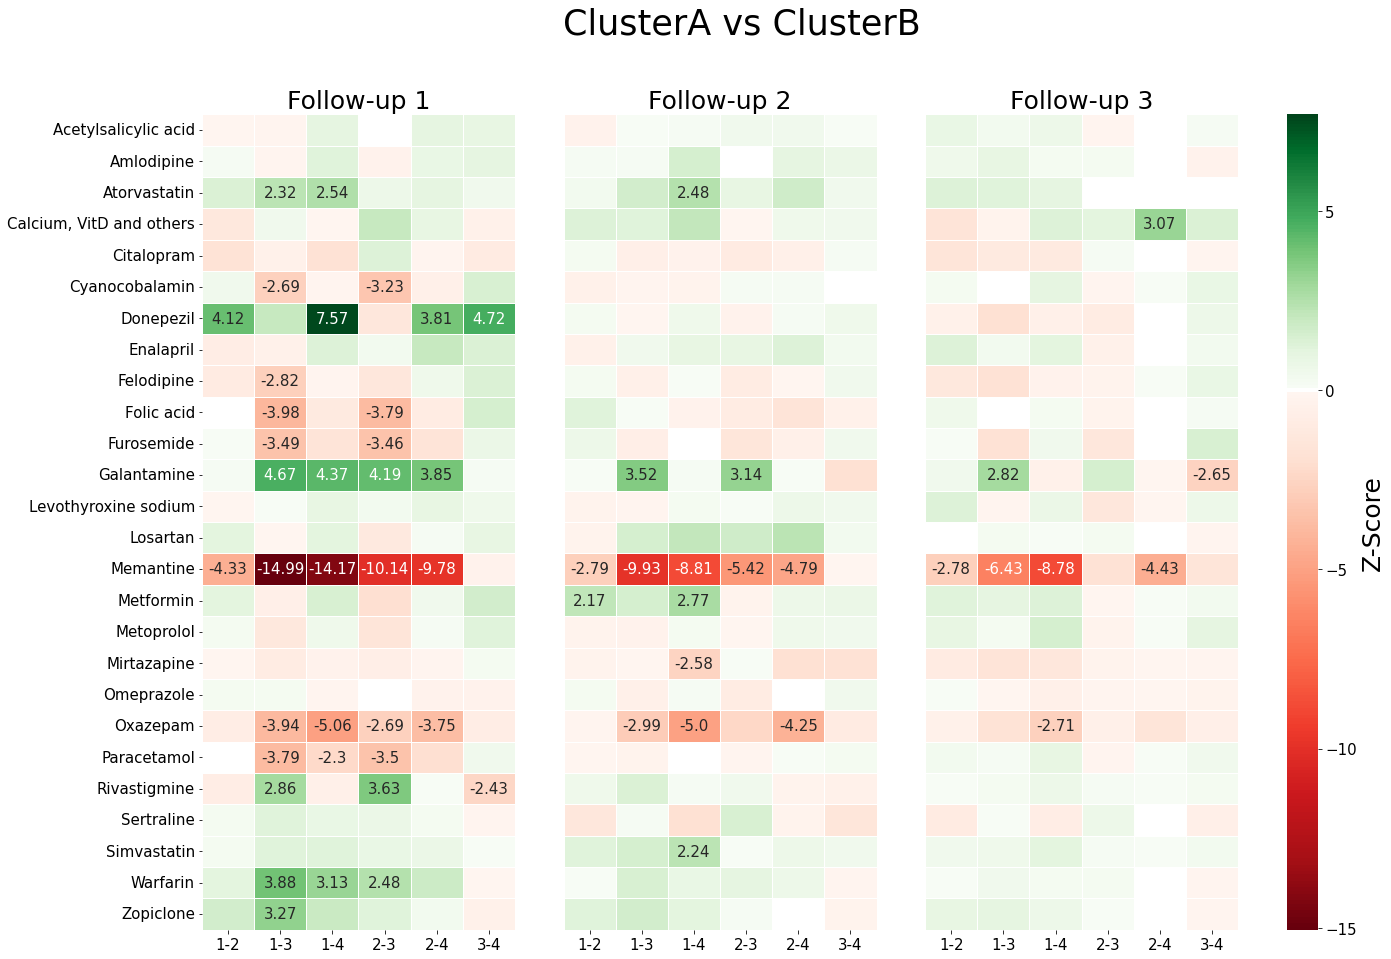

In [43]:
from matplotlib.colors import ListedColormap

%matplotlib inline

# Create the dataframes to plot, with the averaged Z-score, and annotations where the medication is statistically relevant
corr_scores_flag = True

name_drugs_heatmap = drug_vars
names_cols_heatmap = []
for n_FU in range(1, N_FU_max):
    for clst in range(n_clust-1):
        for clst_compare in range(clst+1, n_clust):
            names_cols_heatmap.append("{}FU_clst{}_{}".format(n_FU, clst, clst_compare))
reldrugs_heatmap_df = pd.DataFrame(np.nan, index = name_drugs_heatmap, columns = names_cols_heatmap)
reldrugs_heatmap_nocorr_df = pd.DataFrame(np.nan, index = name_drugs_heatmap, columns = names_cols_heatmap)
reldrugs_heatmap_corr_df = pd.DataFrame(np.nan, index = name_drugs_heatmap, columns = names_cols_heatmap)
for n_FU in range(1, N_FU_max):
    for clst in range(n_clust-1):
        for clst_compare in range(clst+1, n_clust):
            exec(f'reldrugs_heatmap_nocorr_df["{n_FU}FU_clst{clst}_{clst_compare}"] = vars_score_MC_FU{n_FU}_clst{clst}_{clst_compare}_all_df.iloc[:,0]')
            exec(f'reldrugs_heatmap_corr_df["{n_FU}FU_clst{clst}_{clst_compare}"] = vars_score_MC_FU{n_FU}_clst{clst}_{clst_compare}_all_df_corr.iloc[:,0]')
reldrugs_heatmap_corr_df[reldrugs_heatmap_corr_df.isin([np.inf, -np.inf])] = reldrugs_heatmap_nocorr_df[reldrugs_heatmap_corr_df.isin([np.inf, -np.inf])]  # We could not compute False discovery corrected Z-scores due values are too small. Then we assign the original non-corrected, as the efect when it tends to -Inf or +Inf is almost null
if corr_scores_flag == False:
    reldrugs_heatmap_df = reldrugs_heatmap_nocorr_df
else:
    reldrugs_heatmap_df = reldrugs_heatmap_corr_df
reldrugs_heatmap_mask_df = pd.DataFrame(np.nan, index = name_drugs_heatmap, columns = names_cols_heatmap)
reldrugs_heatmap_mask_nocorr_df = pd.DataFrame(np.nan, index = name_drugs_heatmap, columns = names_cols_heatmap)
reldrugs_heatmap_mask_corr_df = pd.DataFrame(np.nan, index = name_drugs_heatmap, columns = names_cols_heatmap)
for n_FU in range(1, N_FU_max):
    for clst in range(n_clust-1):
        for clst_compare in range(clst+1, n_clust):
            exec(f'aux1 = vars_count_MC_FU{n_FU}_clst{clst}_{clst_compare}_df')
            exec(f'aux2 = vars_score_MC_FU{n_FU}_clst{clst}_{clst_compare}_df.copy()')
            exec(f'aux3 = vars_score_MC_FU{n_FU}_clst{clst}_{clst_compare}_df_corr.copy()')
            for col_name in aux1.columns:
                if (aux1.loc['Count', col_name] < np.ceil(0.8*n_MC)):
                    aux2.drop(col_name, inplace=True)
                    aux3.drop(col_name, inplace=True)
            exec(f'reldrugs_heatmap_mask_nocorr_df["{n_FU}FU_clst{clst}_{clst_compare}"] = aux2.iloc[:,0]')
            exec(f'reldrugs_heatmap_mask_corr_df["{n_FU}FU_clst{clst}_{clst_compare}"] = aux3.iloc[:,0]')
reldrugs_heatmap_mask_corr_df[reldrugs_heatmap_mask_corr_df.isin([np.inf, -np.inf])] = reldrugs_heatmap_mask_nocorr_df[reldrugs_heatmap_mask_corr_df.isin([np.inf, -np.inf])]  # We could not compute False discovery corrected Z-scores due values are too small. Then we assign the original non-corrected, as the efect when it tends to -Inf or +Inf is almost null
if corr_scores_flag == False:
    reldrugs_heatmap_mask_df = reldrugs_heatmap_mask_nocorr_df
else:
    reldrugs_heatmap_mask_df = reldrugs_heatmap_mask_corr_df
null_cells = reldrugs_heatmap_mask_df.isnull()
annotations = reldrugs_heatmap_mask_df.astype(float).round(2).astype(str).round(3).mask(null_cells, "")

reldrugs_heatmap_df.fillna(0, inplace=True)

# Colormap plot
#    Create a green-red divergent colormap
color_points = 250
color_separation = np.linspace(min(reldrugs_heatmap_df.min()), max(reldrugs_heatmap_df.max()), color_points-1)
color_sep = (color_separation[2]- color_separation[1])
color_sep_mid = color_sep/2
color_separation = color_separation - color_separation[color_separation > 0][0]
color_separation = np.append(color_separation, color_separation[-1]+color_sep)
len_red = len(color_separation[color_separation < 0])
len_green = len(color_separation[color_separation > 0])
rd_map = plt.cm.get_cmap("Reds", 256)
gr_map = plt.cm.get_cmap("Greens", 256)
newcolors = np.concatenate((rd_map(np.linspace(0, 1, len_red))[::-1], np.array((1, 1, 1, 1)).reshape((1,-1)), gr_map(np.linspace(0, 1, len_green))))
my_cmap = ListedColormap(newcolors)
#    Create the plots
f, axs = plt.subplots(1,4, gridspec_kw={'width_ratios':[1,1,1,0.1]}, figsize=(20, 15))
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]
axcb = axs[3]
xticks = np.array(("1-2", "1-3", "1-4", "2-3", "2-4", "3-4"))
ax1.get_shared_y_axes().join(ax2, ax3)
h1 = sns.heatmap(reldrugs_heatmap_df.iloc[:,:6], annot=annotations.iloc[:,:6], fmt="s", cmap=my_cmap, vmin=min(color_separation)-color_sep_mid, vmax=max(color_separation)+color_sep_mid, annot_kws={"size":15}, xticklabels=xticks, linewidths=1, cbar=False, ax=ax1)
h1.set_title("Follow-up 1", fontsize=25)
h1.set_ylabel("")
h2 = sns.heatmap(reldrugs_heatmap_df.iloc[:,6:12], annot=annotations.iloc[:,6:12], fmt="s", cmap=my_cmap, vmin=min(color_separation)-color_sep_mid, vmax=max(color_separation)+color_sep_mid, annot_kws={"size":15}, xticklabels=xticks, linewidths=1, cbar=False, ax=ax2)
h2.set_title("Follow-up 2", fontsize=25)
h2.set_ylabel("")
h2.set_yticks([])
h3 = sns.heatmap(reldrugs_heatmap_df.iloc[:,12:18], annot=annotations.iloc[:,12:18], fmt="s", cmap=my_cmap, vmin=min(color_separation)-color_sep_mid, vmax=max(color_separation)+color_sep_mid, annot_kws={"size":15}, xticklabels=xticks, linewidths=1, ax=ax3, cbar_ax=axcb, cbar=True)
h3.set_title("Follow-up 3", fontsize=25)
h3.set_ylabel("")
h3.set_yticks([])
cbar = h3.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
h3.figure.axes[3].set_ylabel("Z-Score", size=25)
for ax in [h1, h2, h3]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=0, fontsize=15)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0, fontsize=15)
plt.suptitle("ClusterA vs ClusterB", fontsize=35)
plt.savefig('Analysis Figures/drugs_heatmap.jpg', dpi=300)
plt.show()

# Variance checking for optimal number of Monte-Carlo simulations

In [44]:
Z_stds = []
Z_means = []
for n_FU in range(1, N_FU_max):
    for clst in range(n_clust-1):
        for clst_compare in range(clst+1, n_clust):
            exec(f'Z_stds.append(vars_score_MC_FU{n_FU}_clst{clst}_{clst_compare}_all_df_corr["Std"].max())')
            exec(f'Z_stds.append(vars_score_MC_FU{n_FU}_clst{clst}_{clst_compare}_all_df_corr["Std"].max())')
print(np.max(Z_stds))

0.9215235606508302


In [45]:
CI = 0.99 # Confidence interval
PL = 0.1 # Precision level = sample_mean - population_mean
N_MC_opt = (np.max(Z_stds) * CI / PL)**2
print(N_MC_opt) # With 200 MC simulations (leading to a closer value of the true variance it is around 85. When doing it with 20 MC simulations, it is around 95. We chose 100 simulations to round up and be safe)

83.23064799451761


# Clusters' connection through time

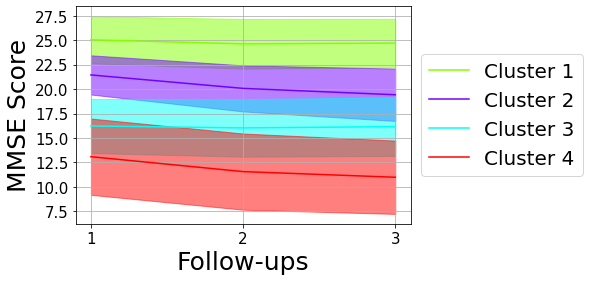

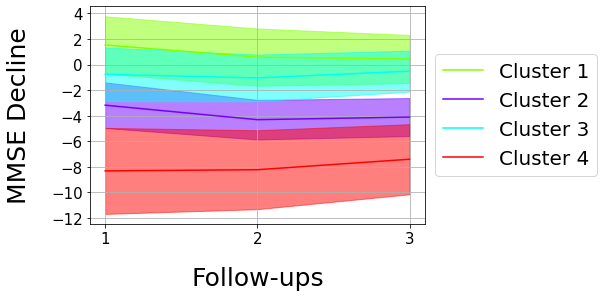

In [35]:
%matplotlib inline
x = np.linspace(1, N_FU_max-1, N_FU_max-1, dtype=int)

palette = plt.cm.hsv(np.linspace(0, 1, n_clust+1))
reord = np.array([1, 3, 2, 0])
new_pal = palette[reord,]

# Clusters' MMSE Score
plt.figure()
for clst in range(n_clust):
    y_mean = []
    y_std = []
    for n_FU in range(1, N_FU_max):
        exec(f'y_mean.append(clst_score_mean_{n_FU}FU)')
        exec(f'y_std.append(clst_score_std_{n_FU}FU)')
y_mean = np.array(y_mean)
y_std = np.array(y_std)
for clst, c in zip(range(n_clust), new_pal):
    plt.plot(x, y_mean[:,clst], label='Cluster {}'.format(clst+1), c = np.array([c]))
    plt.fill_between(x, np.squeeze(np.array(y_mean[:,clst])-np.array(y_std[:,clst])), np.squeeze(np.array(y_mean[:,clst])+np.array(y_std[:,clst])), color = np.array([c]), alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
plt.ylabel('MMSE Score', fontsize=25)
plt.xlabel('Follow-ups', fontsize=25)
plt.xticks(x, fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.savefig('Analysis Figures/MMSE_score_overtime.jpg')
plt.show()

# Clusters' MMSE Decline
plt.figure()
x = np.linspace(1, N_FU_max-1, N_FU_max-1, dtype=int)
for clst in range(n_clust):
    y_mean = []
    y_std = []
    for n_FU in range(1, N_FU_max):
        exec(f'y_mean.append(clst_decl_mean_{n_FU}FU)')
        exec(f'y_std.append(clst_decl_std_{n_FU}FU)')
y_mean = np.array(y_mean)
y_std = np.array(y_std)
for clst, c in zip(range(n_clust), new_pal):
    plt.plot(x, y_mean[:,clst], label='Cluster {}'.format(clst+1), c = np.array([c]))
    plt.fill_between(x, np.squeeze(np.array(y_mean[:,clst])-np.array(y_std[:,clst])), np.squeeze(np.array(y_mean[:,clst])+np.array(y_std[:,clst])), color = np.array([c]), alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
plt.ylabel('MMSE Decline', fontsize=25, labelpad=20)
plt.xlabel('Follow-ups', fontsize=25, labelpad=20)
plt.xticks(x, fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.savefig('Analysis Figures/MMSE_decline_overtime.jpg', dpi=300)
plt.show()

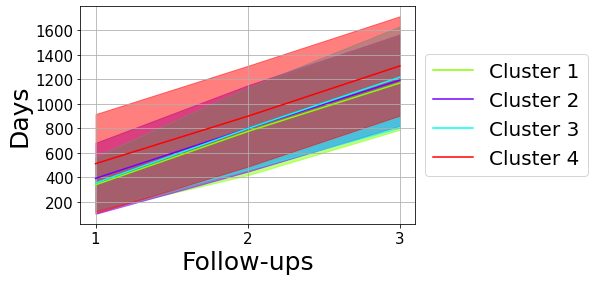

In [36]:
# Plot for days of difference between baseline and follow-up evolution throught time and clusters

plt.figure()
x = np.linspace(1, N_FU_max-1, N_FU_max-1, dtype=int)
for clst in range(n_clust):
    y_mean = []
    y_std = []
    for n_FU in range(1, N_FU_max):
        exec(f'y_mean.append(clst_days_mean_{n_FU}FU)')
        exec(f'y_std.append(clst_days_std_{n_FU}FU)')
y_mean = np.array(y_mean)
y_std = np.array(y_std)
for clst, c in zip(range(n_clust), new_pal):
    plt.plot(x, y_mean[:,clst], label='Cluster {}'.format(clst+1), c = np.array([c]))
    plt.fill_between(x, np.squeeze(np.array(y_mean[:,clst])-np.array(y_std[:,clst])), np.squeeze(np.array(y_mean[:,clst])+np.array(y_std[:,clst])), color = np.array([c]), alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
plt.ylabel('Days', fontsize=25)
plt.xlabel('Follow-ups', fontsize=25)
plt.xticks(x, fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.savefig('Analysis Figures/daysdiff_overtime.jpg', dpi=300)
plt.show()

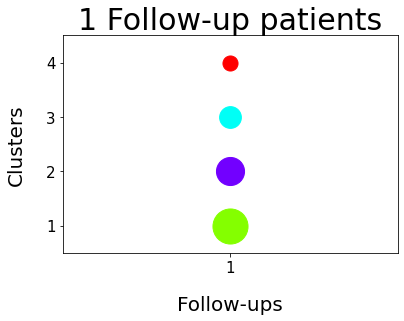

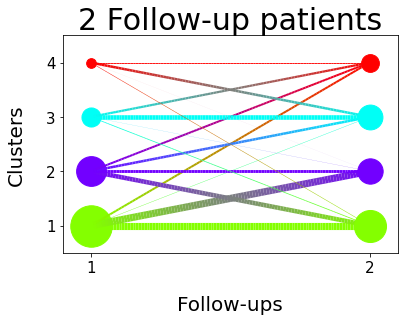

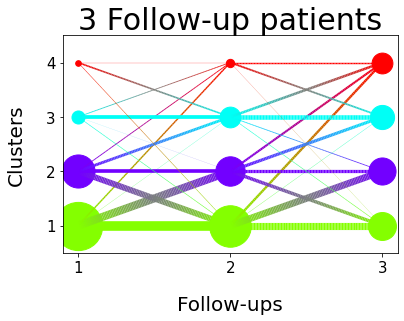

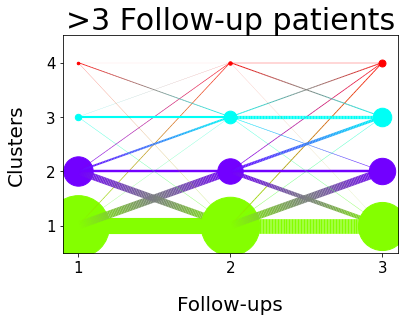

In [88]:
# Plot how patients change along clusters. Dividing into patients with only a follow-up, patients with two follow-ups and patients with three or more follow-ups

from matplotlib.colors import to_hex, LinearSegmentedColormap
import matplotlib.path as mplpath
from matplotlib.collections import LineCollection

%matplotlib inline

vars = ['lopnr', 'N_FOLLOWUP', 'NUMBER_FOLLOWUP']
for n_FU in range(1, N_FU_max):
    exec(f'vars.append("Cluster_{n_FU}FU")')
df = patients_dataset_clst_df[[*vars, 'Memantine']]
df = df[df['NUMBER_FOLLOWUP'] != 0]

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
    z = np.asarray(z)
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)
    ax = plt.gca()
    ax.add_collection(lc)
    return lc

def make_segments(x, y):
    # Cerate list of line segments from x and y coordinates in the correct format for LineCollection: numlines (points per line) x 2 (x and y) 
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis = 1)
    return segments

N = 100
z_1 = np.linspace(0, 1, N) # For the plot new cmap
for n_FU in range(2, N_FU_max+2):
    if n_FU != N_FU_max+1:
        n_FU_aux = n_FU
        df_nFU = df[df['N_FOLLOWUP'] == n_FU].copy()
    else:
        n_FU_aux = n_FU-1
        df_nFU = df[df['N_FOLLOWUP'] >= n_FU].copy()
    df_nFU.drop(['N_FOLLOWUP', 'NUMBER_FOLLOWUP'], axis=1, inplace=True)
    df_nFU = df_nFU.groupby('lopnr').first().reset_index()
    df_nFU.drop('lopnr', axis=1, inplace=True)
    df_nFU = df_nFU.iloc[:,:n_FU_aux-1]
    df_nFU.columns = np.array(range(1,n_FU_aux))
    plt.figure()
    palette = plt.cm.hsv(np.linspace(0, 1, n_clust+1))
    for i in range(1, n_FU_aux):
        points = df_nFU.iloc[:,i-1].value_counts()
        if i != n_FU_aux-1:
            aux_1 = df_nFU.iloc[:,i-1].value_counts()
        for clst, c in zip(range(n_clust), new_pal):
            plt.plot(i, clst+1, '.', markersize=(200*points[clst]/points.sum()), c = np.array([c])) # Plot points
            if i != n_FU_aux-1:
                future_clst = df_nFU[df_nFU[i] == clst].astype(int)[i+1].value_counts().reindex(np.array(range(n_clust)), fill_value=0)
                for clst_next in range(n_clust):
                    aux_2 = df_nFU[df_nFU[i] == clst]
                    x = np.array([i, i+1])
                    y = np.array([clst, clst_next])
                    cmap_new = LinearSegmentedColormap.from_list("", [to_hex(new_pal[clst, 0:3]), to_hex(new_pal[clst_next, 0:3])])
                    mpath = mplpath.Path(np.column_stack([x, y+1]))
                    verts = mpath.interpolated(steps=N).vertices
                    x, y = verts[:, 0], verts[:, 1]
                    colorline(x, y, cmap = cmap_new, linewidth=(40*future_clst[clst_next]/points.sum()))
    plt.xlabel("Follow-ups", fontsize=20, labelpad=20)
    plt.ylabel("Clusters", fontsize=20, labelpad=20)
    if n_FU != N_FU_max+1:
        plt.title("{} Follow-up patients".format(n_FU-1), fontsize=30)
    else: 
        plt.title(">{} Follow-up patients".format(n_FU-2), fontsize=30)
    plt.xticks(range(1,n_FU_aux), fontsize=15)
    plt.yticks(range(1,n_clust+1), fontsize=15)
    plt.ylim(0.5,4.5)
    plt.xlim(0.9, n_FU_aux-0.9)
    plt.show()


In [89]:
%reset